In [1]:
%cd ..

d:\github\ripple_heterogeneity\python


In [2]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
# def plot_sequences()

def get_color_code(cell_metrics):
    colors1 = []
    for i in range(len(cell_metrics['deepSuperficial'])):
        if cell_metrics.deepSuperficial.iloc[i]=='Deep':
            # colors1.append('#7b3294') 
            colors1.append('r')  
        elif cell_metrics.deepSuperficial.iloc[i]=="Superficial":
            # colors1.append('#008837') 
            colors1.append('k') 
        else:
            colors1.append('grey') 
    return colors1

def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_st_rip(ripples,data,fs_dat,restrict_idx):
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

    st = nel.SpikeTrainArray(
                        timestamps=np.array(np.array(data['spikes'],dtype=object)[restrict_idx],dtype="object"),
                        fs=fs_dat)
    return st[ripple_epochs]

def plot_seq(st_rip,ripples,rip,ax,colors1):
    rip = int(rip)
    order_idx = np.array(st_rip[rip].get_event_firing_order())-1
    
    ax.eventplot(st_rip[rip].data[order_idx],
                colors=np.array(colors1)[order_idx],
                linewidth=3.5)
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.set_ylim(-1,st_rip[rip].n_active+1)
    ax.set_xlim(ripples.start.loc[rip],ripples.stop.loc[rip])
    # set x axis to start at 0
    x = np.linspace(ripples.start.loc[rip],ripples.stop.loc[rip],4)
    ax.set_xticks(x)
    ax.set_xticklabels(np.round(x - x.min(),3)) 

def make_subplot(st_rip,fig_save_path,colors1,basename,rows=8,cols=5,save_fig=True):

    fig, axs = plt.subplots(rows,cols,
            figsize=functions.set_size('thesis', fraction=5, subplots=(rows, cols)), edgecolor='k')
    fig.subplots_adjust(hspace = .15, wspace=.2)
    axs = axs.ravel()

    print("sorting events by n units")
    n_active = []
    for event in st_rip:
        n_active.append(event.n_active)

    for i,rip in enumerate(np.sort(np.argsort(n_active)[::-1][:rows*cols])):
        plot_seq(st_rip,ripples,rip,axs[i],colors1)
        axs[i].axes.get_yaxis().set_ticks([])
        axs[i].set_title("rip #: "+str(rip))

    if save_fig:
        plt.savefig(os.path.join(fig_save_path,basename+'_sequence_explore.pdf'),
                    dpi=300,bbox_inches='tight')



# plot many sequences

In [112]:
fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'
basepath = r'A:\\Data\\AB3\\AB3_60'
basename = os.path.basename(os.path.normpath(basepath))

# get basic data
cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)
# get spike train with cell restrictions

# brain_idx = np.where((cell_metrics.brainRegion.values=="lCA1") | (cell_metrics.brainRegion.values=="rCA1"))
restrict_idx = (cell_metrics.putativeCellType == "Pyramidal Cell") & (cell_metrics.brainRegion=="CA1")
st_rip = get_st_rip(ripples,data,fs_dat,restrict_idx)
# colorcode
colors1 = get_color_code(cell_metrics[restrict_idx])
# make the plots
make_subplot(st_rip,fig_save_path,colors1,basename)

'G:/My Drive/post_doc/ripple_diversity/project_logAchilles_11012013\\'

# Run analysis

In [4]:
def pairwise_corr(spks):
    # Get unique combo without repeats
    x = np.arange(0,spks.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    for i,s in enumerate(c):	
        # Calling the crossCorr function
        rho_, pval_ = stats.spearmanr(spks[s[0],:], spks[s[1],:])
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval

def run_analysis(basepath,dt=0.001,smooth_sigma=0.0015):
    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))
    # restric cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]
    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

    # make population spike trains 
    idx = (cell_metrics.deepSuperficial=="Deep")
    st_deep = nel.SpikeTrainArray(timestamps=np.sort(np.hstack(np.array(data['spikes'],dtype=object)[restrict_idx][idx])), fs=fs_dat)
    idx = (cell_metrics.deepSuperficial=="Superficial")
    st_sup = nel.SpikeTrainArray(timestamps=np.sort(np.hstack(np.array(data['spikes'],dtype=object)[restrict_idx][idx])), fs=fs_dat)
    st_deep_rip = st_deep[ripple_epochs]
    st_sup_rip = st_sup[ripple_epochs]

    # make isi
    isi_deep = np.diff(st_deep_rip.data[0])
    isi_deep = isi_deep[isi_deep<0.1]

    isi_sup = np.diff(st_sup_rip.data[0])
    isi_sup = isi_deep[isi_sup<0.1]

    mean_pop_isi_deep = isi_deep.mean()
    mean_pop_isi_sup = isi_sup.mean()

    # make spike trains for single units
    idx = (cell_metrics.deepSuperficial=="Deep")
    st_deep_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx][idx], fs=fs_dat)
    idx = (cell_metrics.deepSuperficial=="Superficial")
    st_sup_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx][idx], fs=fs_dat)
    st_deep_rip_unit = st_deep_unit[ripple_epochs]
    st_sup_rip_unit = st_sup_unit[ripple_epochs]

    # bin unit spike trains
    st_deep_binned_unit = st_deep_rip_unit.bin(ds=dt)
    st_sup_binned_unit = st_sup_rip_unit.bin(ds=dt)

    # smooth spike trains
    st_deep_binned_unit.smooth(sigma=0.0015,inplace=True)
    st_sup_binned_unit.smooth(sigma=0.0015,inplace=True)

    ripple_co_fire_rho_deep,ripple_co_fire_pval_deep = pairwise_corr(st_deep_binned_unit.data)
    ripple_co_fire_rho_sup,ripple_co_fire_pval_sup = pairwise_corr(st_sup_binned_unit.data)
    



basepath = r'A:\Data\GrosmarkAD\Achilles\Achilles_11012013'


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


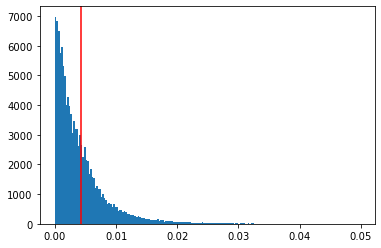

In [108]:
isi_deep = np.diff(st_deep_rip.data[0])
isi_deep = isi_deep[isi_deep<0.1]
plt.hist(isi_deep,bins=np.arange(0,0.05,0.00025))
plt.axvline(isi_deep.mean(),color='r')
plt.show()

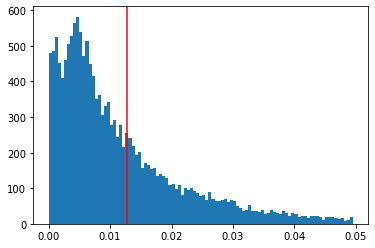

In [90]:
isi_sup = np.diff(st_sup_rip.data[0])
isi_sup = isi_sup[isi_sup<0.1]
plt.hist(isi_sup,bins=np.arange(0,0.05,0.0005))
plt.axvline(isi_sup.mean(),color='r')
plt.show()

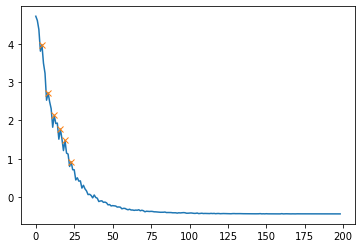

In [112]:
from scipy.signal import find_peaks

[values,bin_edges] = np.histogram(isi_deep,bins=np.arange(0,0.05,0.00025))
values = stats.zscore(values)
peaks, _ = find_peaks(values,prominence=.1)
# plt.plot(values)

plt.plot(values)
plt.plot(peaks, values[peaks], "x")
# plt.xscale("log")

In [23]:
# from scipy.stats import variation
# from elephant import statistics

# print(statistics.cv2(st_deep_rip.data[0]))
# print(variation(st_deep_rip.data[0]))
# statistics.lv(st_deep_rip.data[0])
# from elephant.conversion import BinnedSpikeTrain
# from elephant.spike_train_correlation import correlation_coefficient
# BinnedSpikeTrain(st_deep_rip_unit.data)


In [49]:
def compute_AutoCorrs(spks, binsize = 0.001, nbins = 100):
    # First let's prepare a pandas dataframe to receive the data
    times = np.arange(0, binsize*(nbins+1), binsize) - (nbins*binsize)/2	
    autocorrs = pd.DataFrame(index = times, columns = np.arange(len(spks)))

    # Now we can iterate over the dictionnary of spikes
    for i,s in enumerate(spks):		
        # Calling the crossCorr function
        autocorrs[i] = functions.crossCorr(s, s, binsize, nbins)

    return autocorrs

In [75]:
autocorrs_deep = functions.compute_AutoCorrs(st_deep_rip.data, binsize = 0.0005, nbins = 200)
autocorrs_sup = functions.compute_AutoCorrs(st_sup_rip.data, binsize = 0.0005, nbins = 200)

In [76]:
binsize = 0.0005
nbins = 200
times = np.arange(0, binsize*(nbins+1), binsize) - (nbins*binsize)/2	
crosscorrs = pd.DataFrame(index = times, columns = np.arange(len(st_deep_rip.data)))

crosscorrs[0] = functions.crossCorr(st_deep_rip.data[0], st_sup_rip.data[0], binsize, nbins)
crosscorrs.loc[0] = 0.0

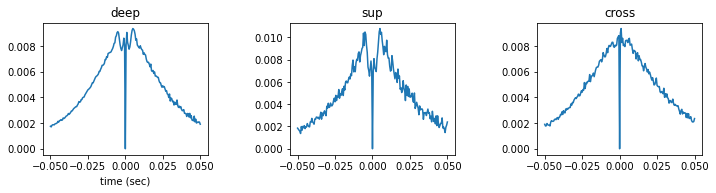

In [90]:
fig, axs = plt.subplots(1,3,figsize=functions.set_size('thesis', fraction=2, subplots=(1, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.5)
axs = axs.ravel()

axs[0].plot(autocorrs_deep / autocorrs_deep.sum(),label="deep")
axs[1].plot(autocorrs_sup / autocorrs_sup.sum(),label="sup")
axs[2].plot(crosscorrs / crosscorrs.sum(),label="cross")

axs[0].set_title("deep")
axs[1].set_title("sup")
axs[2].set_title("cross")

axs[0].set_xlabel("time (sec)")
plt.savefig(os.path.join(fig_save_path,'auto_cross_examples.pdf'),dpi=300,bbox_inches='tight')
plt.savefig(os.path.join(fig_save_path,'auto_cross_examples.png'),dpi=300,bbox_inches='tight')


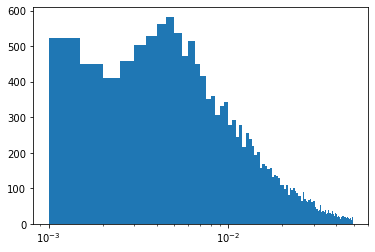

In [115]:
plt.hist(np.diff(st_sup_rip.data[0]),bins=np.arange(0.001,0.05,0.0005))
plt.xscale("log")
plt.show()

# pairwise cross corr for each group

In [75]:
import itertools
from scipy import stats

def pairwise_cross_corr(spks, binsize = 0.001, nbins = 100):
    # Get unique combo without repeats
    x = np.arange(0,spks.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    # prepare a pandas dataframe to receive the data
    times = np.arange(0, binsize*(nbins+1), binsize) - (nbins*binsize)/2	
    crosscorrs = pd.DataFrame(index = times,columns = np.arange(len(c)))

    # Now we can iterate over spikes
    for i,s in enumerate(c):	
        # Calling the crossCorr function
        crosscorrs[i] = functions.crossCorr(spks[s[0]], spks[s[1]], binsize, nbins)
    return crosscorrs

def pairwise_corr(spks):
    # Get unique combo without repeats
    x = np.arange(0,spks.shape[0])
    c = np.array(list(itertools.combinations(x, 2)))
    rho = []
    pval = []
    for i,s in enumerate(c):	
        # Calling the crossCorr function
        rho_, pval_ = stats.spearmanr(spks[s[0],:], spks[s[1],:])
        rho.append(rho_)
        pval.append(pval_)
    return rho,pval

dt = 0.001
# st_deep_binned = st_deep_rip_unit.bin(ds=dt)
st_sup_binned = st_sup_rip_unit.bin(ds=dt)

# st_deep_binned.smooth(sigma=0.0015,inplace=True)
st_sup_binned.smooth(sigma=0.0015,inplace=True)

# rho = pairwise_corr(st_deep_binned.data)

# crosscorrs_sup = pairwise_cross_corr(st_sup_rip_unit.data, binsize = 0.001, nbins = 100)
# crosscorrs_deep = pairwise_cross_corr(st_deep_rip_unit.data, binsize = 0.001, nbins = 100)


<BinnedSpikeTrainArray at 0x279e21010d0: 15 series (10,056 segments) in 653,454 bins of width 1.0 milliseconds> for a total of 10:53:454 minutes

In [80]:
ripple_co_fire_rho_sup,ripple_co_fire_pval_sup = pairwise_corr(st_sup_binned.data)


0.007436562355754767 1.8378223111921938e-09


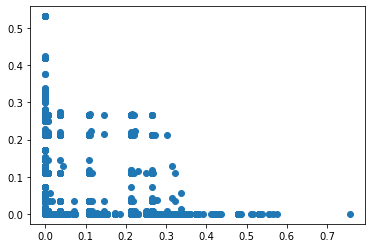

In [89]:
spks = st_sup_binned.data
x = np.arange(0,spks.shape[0])
c = np.array(list(itertools.combinations(x, 2)))

s = c[10]
rho_, pval_ = stats.spearmanr(spks[s[0],:], spks[s[1],:])
print(rho_,pval_)
plt.scatter(spks[s[0],:],spks[s[1],:])
# plt.plot(spks[s[0],:])

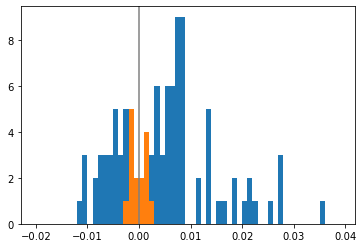

In [88]:
plt.hist(np.array(rho)[np.array(pval)<0.05],bins=np.arange(-0.02,0.04,0.001))
plt.hist(np.array(rho)[np.array(pval)>0.05],bins=np.arange(-0.02,0.04,0.001))
plt.axvline(0,color='grey')
plt.show()

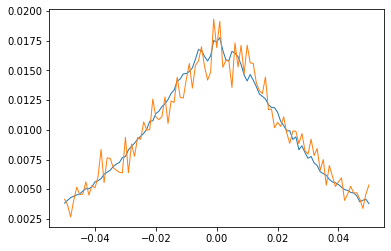

In [200]:
# plt.plot(crosscorrs_deep / crosscorrs_deep.sum())
# plt.plot(np.mean(crosscorrs_deep / crosscorrs_deep.sum(),axis=1),color="k",linewidth=4)
# # plt.ylim(0,.2)
# plt.show()
from scipy import stats
stats.zscore
crosscorrs_deep.zscore()
plt.plot(np.mean(crosscorrs_deep / crosscorrs_deep.sum(),axis=1),linewidth=1)
plt.plot(np.mean(crosscorrs_sup / crosscorrs_sup.sum(),axis=1),linewidth=1)


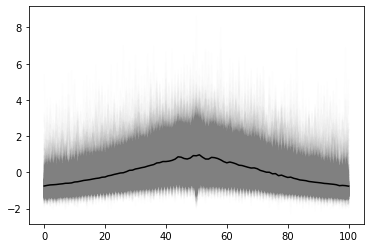

In [208]:
from scipy import stats

plt.plot(stats.zscore(crosscorrs_deep),color="grey",alpha=.01)
plt.plot(np.mean(stats.zscore(crosscorrs_deep),axis=1),color="k")

plt.show()


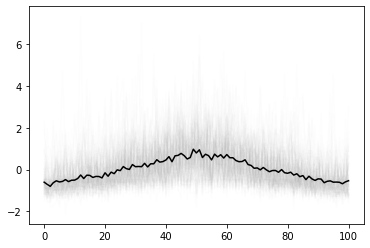

In [209]:
plt.plot(stats.zscore(crosscorrs_sup),color="grey",alpha=.01)
plt.plot(np.mean(stats.zscore(crosscorrs_sup),axis=1),color="k")

plt.show()

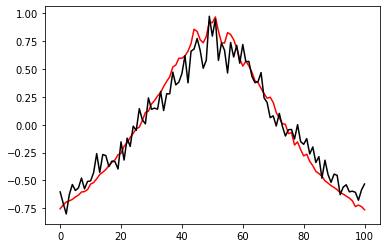

In [211]:
plt.plot(np.mean(stats.zscore(crosscorrs_deep),axis=1),color="r")
plt.plot(np.mean(stats.zscore(crosscorrs_sup),axis=1),color="k")



# example analysis below

In [4]:
basepath = r'A:\\Data\\AB3\\AB3_60'
ripples = loading.load_ripples_events(basepath)

nChannels, fs, fs_dat, shank_to_channel = loading.loadXML(basepath)

filename = glob.glob(os.path.join(basepath,'*.lfp'))[0]
lfp,timestep = loading.loadLFP(filename,
                                n_channels=nChannels,
                                channel=ripples.ripple_channel.loc[0] - 1,
                                frequency=fs,
                                precision='int16')
lfp = nel.AnalogSignalArray(lfp, fs=fs)

cell_metrics,data = loading.load_cell_metrics(basepath)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


In [6]:
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
ripple_epochs
# brain_idx = np.where((cell_metrics.brainRegion.values=="lCA1") | (cell_metrics.brainRegion.values=="rCA1"))

# st_rip = st[ripple_epochs]

<EpochArray at 0x145d6326ee0: 138 epochs> of length 6.7584 seconds

# bin and smooth spike trains from deep and superficial pyr units

In [7]:
idx = (cell_metrics.putativeCellType=="Pyramidal Cell") & (cell_metrics.deepSuperficial=="Deep") & (cell_metrics.brainRegion=="CA1")
st_deep = nel.SpikeTrainArray(timestamps=np.sort(np.hstack(np.array(data['spikes'],dtype=object)[idx])), fs=fs_dat)


idx = (cell_metrics.putativeCellType=="Pyramidal Cell") & (cell_metrics.deepSuperficial=="Superficial") & (cell_metrics.brainRegion=="CA1")
st_sup = nel.SpikeTrainArray(timestamps=np.sort(np.hstack(np.array(data['spikes'],dtype=object)[idx])), fs=fs_dat)

st_deep_rip = st_deep[ripple_epochs]
st_sup_rip = st_sup[ripple_epochs]

dt = 0.001
st_deep_binned = st_deep_rip.bin(ds=dt)
st_sup_binned = st_sup_rip.bin(ds=dt)


In [8]:
st_deep_binned.smooth(sigma=0.0015,inplace=True)
st_sup_binned.smooth(sigma=0.0015,inplace=True)

<BinnedSpikeTrainArray at 0x145d5cca7f0: 1 series (138 segments) in 6,693 bins of width 1.0 milliseconds> for a total of 6.693 seconds

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_20364/1120734344.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

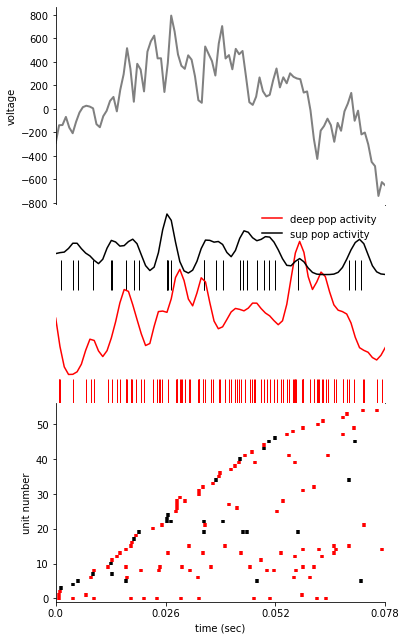

In [9]:
def plot_ripple_sequence_deep_sup(rip_n,lfp,ripple_epochs,st_deep_rip,st_sup_rip,st_deep_binned,st_sup_binned,cell_metrics):

    # rip_n = 1944

    fig, axs = plt.subplots(3,1,figsize=functions.set_size('thesis', fraction=1, subplots=(3, 1)), edgecolor='k')
    fig.subplots_adjust(hspace = 0, wspace=.2)
    axs = axs.ravel()

    lfp_trace = lfp[ripple_epochs][rip_n].data.T
    x = np.linspace(ripple_epochs[rip_n].start,ripple_epochs[rip_n].stop,len(lfp_trace))
    axs[0].plot(x,lfp_trace,color="grey",linewidth=2)
    axs[0].set_xlim(ripple_epochs[rip_n].start,ripple_epochs[rip_n].stop)
    axs[0].axes.get_xaxis().set_ticks([])

    axs[1].plot(st_deep_rip[rip_n].data[0],np.ones_like(st_deep_rip[rip_n].data[0]),"|",markersize=30,color="r")
    axs[1].plot(st_sup_rip[rip_n].data[0],np.ones_like(st_sup_rip[rip_n].data[0])+2,"|",markersize=30,color="k")
    axs[1].set_xlim(ripple_epochs[rip_n].start,ripple_epochs[rip_n].stop)
    # axs[1].set_ylim(0,4)

    x = np.linspace(ripple_epochs[rip_n].start,ripple_epochs[rip_n].stop,len(st_deep_binned[rip_n].data.T))

    axs[1].plot(x,st_deep_binned[rip_n].data.T+1,color='r',label="deep pop activity")
    axs[1].plot(x,st_sup_binned[rip_n].data.T+3,color='k',label="sup pop activity")

    restrict_idx = (cell_metrics.putativeCellType == "Pyramidal Cell") & (cell_metrics.brainRegion=="CA1")
    st_rip = get_st_rip(ripples,data,fs_dat,restrict_idx)
    colors1 = get_color_code(cell_metrics[restrict_idx])
    plot_seq(st_rip,ripples,rip_n,axs[2],colors1)

    for i in range(3):
        right_side = axs[i].spines["right"]
        right_side.set_visible(False)
        top_side = axs[i].spines["top"]
        top_side.set_visible(False)

    axs[1].axes.get_xaxis().set_ticks([])
    axs[1].axes.get_yaxis().set_ticks([])
    axs[1].spines["left"].set_visible(False)

    axs[1].legend(frameon=False)


    axs[2].set_ylabel("unit number")
    axs[2].set_xlabel("time (sec)")

    axs[0].set_ylabel("voltage")

plot_ripple_sequence_deep_sup(20,lfp,ripple_epochs,st_deep_rip,st_sup_rip,st_deep_binned,st_sup_binned,cell_metrics)

# plt.savefig(os.path.join(fig_save_path,'sequence_pop_example.pdf'),dpi=300,bbox_inches='tight')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_20364/1120734344.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

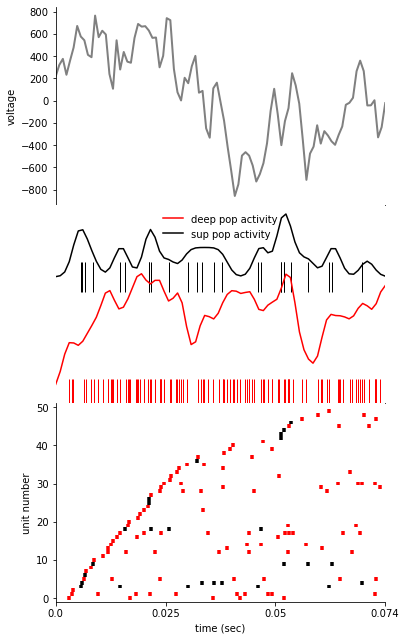

In [10]:
plot_ripple_sequence_deep_sup(131,lfp,ripple_epochs,st_deep_rip,st_sup_rip,st_deep_binned,st_sup_binned,cell_metrics)
plt.savefig(os.path.join(fig_save_path,'sequence_pop_example_131.pdf'),dpi=300,bbox_inches='tight')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
<ipython-input-21-1d1d4021e059>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

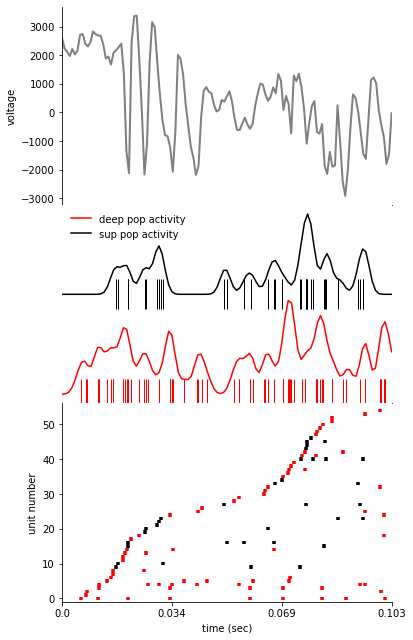

In [65]:
plot_ripple_sequence_deep_sup(740,lfp,ripple_epochs,st_deep_rip,st_sup_rip,st_deep_binned,st_sup_binned,cell_metrics)
